In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import *
pd.set_option('display.max_columns', 100)

In [2]:
data = pd.read_excel('ENB2012_data.xlsx')
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
data.columns= ["Relative Compactness","Surface Area","Wall Area","Roof Area","Overall Height","Orientation",
               "Glazing Area","Glazing Area Distribution","Heating Load","Cooling Load"]
data.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
# combining both heating & cooling loads
data['Overall Load'] = data['Heating Load'] + data['Cooling Load']
data.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,Overall Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,36.88
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,36.88
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,36.88
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,36.88
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,49.12


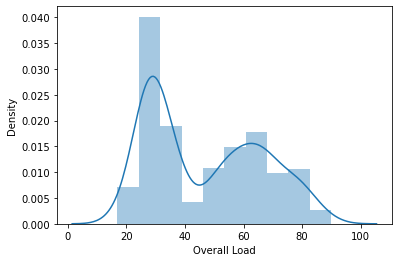

In [5]:
# visualize trend of overall load
sns.distplot(data['Overall Load']);

Mean overall load: 46.89495572916663
Median overall load: 40.97


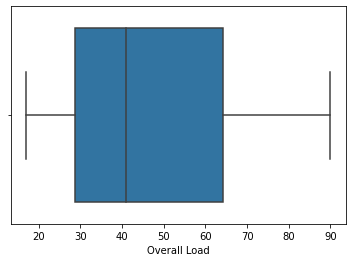

In [6]:
print('Mean overall load:', data['Overall Load'].mean())
print('Median overall load:', data['Overall Load'].median())
sns.boxplot(data['Overall Load']);

In [7]:
# lets find quantiles for this feature
data['Overall Load'].quantile([0.25,0.50,0.75])

0.25    28.750
0.50    40.970
0.75    64.335
Name: Overall Load, dtype: float64

In [8]:
# lets create new column Efficiency. Based on quantile values we shall assign Low, Average & High
lower_lim = data['Overall Load'].quantile(0.25)
upper_lim = data['Overall Load'].quantile(0.75)

def getEfficiency(df):
    if df['Overall Load'] < lower_lim:
        val = 'Low'
    elif df['Overall Load'] >= lower_lim and df['Overall Load'] < upper_lim:
        val = 'Average'
    else:
        val = 'High'
    return val

data['Efficiency'] = data.apply(getEfficiency, axis=1)
data.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,Overall Load,Efficiency
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,36.88,Average
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,36.88,Average
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,36.88,Average
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,36.88,Average
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,49.12,Average


In [9]:
data['Efficiency'].value_counts()

Average    384
High       192
Low        192
Name: Efficiency, dtype: int64

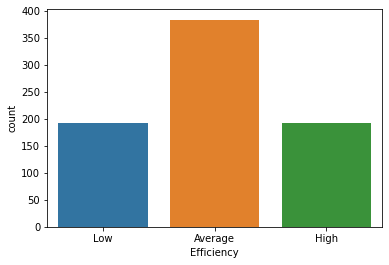

In [10]:
sns.countplot(x='Efficiency', data=data, order=['Low','Average','High']);

# Data for Heating Load

In [11]:
data_heat = data.drop(columns=['Cooling Load','Overall Load','Efficiency'])
data_heat

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48


# Data for Cooling Load

In [12]:
data_cool = data.drop(columns=['Heating Load','Overall Load','Efficiency'])
data_cool

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.61


# Data for Efficiency

In [13]:
data_eff = data.drop(columns=['Cooling Load','Heating Load','Overall Load'])
data_eff

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Efficiency
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,Average
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,Average
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,Average
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,Average
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,Average
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,Average
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,Average
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,Average
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,Average


# Modelling for Heating Load

In [14]:
X = data_heat.drop(columns=['Heating Load'])
y = data_heat['Heating Load']

In [15]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

### 1. Linear Regression

In [16]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('R2 of Linear Regression on training set:{:.2f}'.format(lr.score(X_train, y_train)))
print('R2 of Linear Regression on test set:{:.2f}'.format(lr.score(X_test, y_test)))
r2_lr = r2_score(y_test, y_pred)
print(r2_lr)

R2 of Linear Regression on training set:0.92
R2 of Linear Regression on test set:0.91
0.9147515395877057


### 2. Decision Tree

In [17]:
dt = DecisionTreeRegressor()
param_grid = {'max_depth':[2,4,6,8,10]}
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train,y_train)
grid_search.best_params_

{'max_depth': 8}

In [18]:
dt = DecisionTreeRegressor(max_depth=8).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print('R2 of Decision Tree Regressor on training set:{}'.format(dt.score(X_train, y_train)))
print('R2 of Decision Tree Regressor on test set:{}'.format(dt.score(X_test, y_test)))
r2_dt = r2_score(y_test, y_pred)
print(r2_dt)

R2 of Decision Tree Regressor on training set:0.9992710026423552
R2 of Decision Tree Regressor on test set:0.9965385754795707
0.9965385754795707


### 3. Random Forest

In [19]:
param_grid = {'max_features':[2,4,6,8],
              'max_depth':[2,4,6,8],
              'max_leaf_nodes':[2,4,6,8]}
rf = RandomForestRegressor(random_state=10)
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_depth': 6, 'max_features': 6, 'max_leaf_nodes': 8}

In [20]:
rf = RandomForestRegressor(max_depth=6, max_features=6, max_leaf_nodes=8, random_state=10).fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('R2 of Random Forest Regressor on training set:{:.2f}'.format(rf.score(X_train, y_train)))
print('R2 of Random Forest Regressor on test set:{:.2f}'.format(rf.score(X_test, y_test)))
r2_rf = r2_score(y_test, y_pred)
print(r2_rf)

R2 of Random Forest Regressor on training set:0.97
R2 of Random Forest Regressor on test set:0.96
0.9564455631456904


### 4. Gradient Boosting

In [21]:
gb = GradientBoostingRegressor(max_depth=4)
param_grid = {'learning_rate':[0.1,1,10,100],
              'n_estimators':[5,10,20,50]}
grid_search = GridSearchCV(gb, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'learning_rate': 1, 'n_estimators': 50}

In [22]:
gb = GradientBoostingRegressor(max_depth=4, learning_rate=1, n_estimators=50).fit(X_train, y_train)
y_pred = gb.predict(X_test)
print('R2 of Gradient Boosting Regressor on training set:{}'.format(gb.score(X_train, y_train)))
print('R2 of Gradient Boosting Regressor on test set:{}'.format(gb.score(X_test, y_test)))
r2_gb = r2_score(y_test, y_pred)
print(r2_gb)

R2 of Gradient Boosting Regressor on training set:0.9997551481968803
R2 of Gradient Boosting Regressor on test set:0.9981389057560808
0.9981389057560808


## Comparing all Models

In [23]:
data_dict = {'LinearRegression':r2_lr,
             'DecisionTree':r2_dt,
             'RandomForest':r2_rf,
             'GradientBoosting':r2_gb}
methods = list(data_dict.keys())
scores = list(data_dict.values())

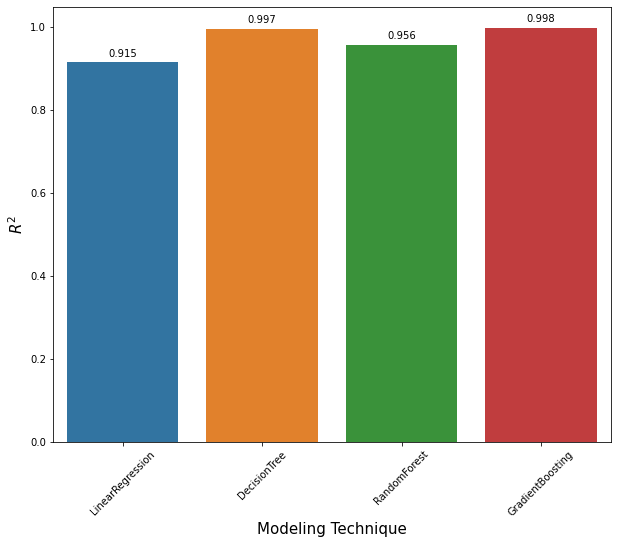

In [24]:
plt.figure(figsize=(10,8))
splot = sns.barplot(methods, scores)
for p in splot.patches:
    splot.annotate(format(p.get_height(),'.3f'), (p.get_x()+p.get_width()/2., p.get_height()),
                   ha='center', va='center', xytext=(0,9), textcoords='offset points')    
plt.xticks(rotation=45)
plt.xlabel('Modeling Technique', fontsize=15)
plt.ylabel('$R^2$', fontsize=15);

As seen from above bar chart, Gradient Boosting Regressor produces best R2_score of 0.998. Hence this can be a good model to predict Heating Load

# Modelling for Cooling Load

In [25]:
X = data_cool.drop(columns=['Cooling Load'])
y = data_cool['Cooling Load']

In [26]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

### 1. Linear Regression

In [27]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('R2 of Linear Regression on training set:{:.2f}'.format(lr.score(X_train, y_train)))
print('R2 of Linear Regression on test set:{:.2f}'.format(lr.score(X_test, y_test)))
r2_lr = r2_score(y_test, y_pred)
print(r2_lr)

R2 of Linear Regression on training set:0.89
R2 of Linear Regression on test set:0.89
0.892446658152522


### 2. Decision Tree

In [28]:
dt = DecisionTreeRegressor()
param_grid = {'max_depth':[2,4,6,8,10]}
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train,y_train)
grid_search.best_params_

{'max_depth': 6}

In [29]:
dt = DecisionTreeRegressor(max_depth=6).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print('R2 of Decision Tree Regressor on training set:{}'.format(dt.score(X_train, y_train)))
print('R2 of Decision Tree Regressor on test set:{}'.format(dt.score(X_test, y_test)))
r2_dt = r2_score(y_test, y_pred)
print(r2_dt)

R2 of Decision Tree Regressor on training set:0.9753913875987169
R2 of Decision Tree Regressor on test set:0.9650350273065316
0.9650350273065316


### 3. Random Forest 

In [30]:
param_grid = {'max_features':[2,4,6,8],
              'max_depth':[2,4,6,8],
              'max_leaf_nodes':[2,4,6,8]}
rf = RandomForestRegressor(random_state=10)
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_depth': 6, 'max_features': 4, 'max_leaf_nodes': 8}

In [31]:
rf = RandomForestRegressor(max_depth=6, max_features=4, max_leaf_nodes=8, random_state=10).fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('R2 of Random Forest Regressor on training set:{:.2f}'.format(rf.score(X_train, y_train)))
print('R2 of Random Forest Regressor on test set:{:.2f}'.format(rf.score(X_test, y_test)))
r2_rf = r2_score(y_test, y_pred)
print(r2_rf)

R2 of Random Forest Regressor on training set:0.94
R2 of Random Forest Regressor on test set:0.93
0.9329300306375364


### 4. Gradient Boosting

In [32]:
gb = GradientBoostingRegressor(max_depth=4)
param_grid = {'learning_rate':[0.1,1,10,100],
              'n_estimators':[5,10,20,50]}
grid_search = GridSearchCV(gb, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'learning_rate': 1, 'n_estimators': 50}

In [33]:
gb = GradientBoostingRegressor(max_depth=4, learning_rate=1, n_estimators=50).fit(X_train, y_train)
y_pred = gb.predict(X_test)
print('R2 of Gradient Boosting Regressor on training set:{}'.format(gb.score(X_train, y_train)))
print('R2 of Gradient Boosting Regressor on test set:{}'.format(gb.score(X_test, y_test)))
r2_gb = r2_score(y_test, y_pred)
print(r2_gb)

R2 of Gradient Boosting Regressor on training set:0.998569234366174
R2 of Gradient Boosting Regressor on test set:0.9940100560675461
0.9940100560675461


## Comparing all Models

In [34]:
data_dict = {'LinearRegression':r2_lr,
             'DecisionTree':r2_dt,
             'RandomForest':r2_rf,
             'GradientBoosting':r2_gb}
methods = list(data_dict.keys())
scores = list(data_dict.values())

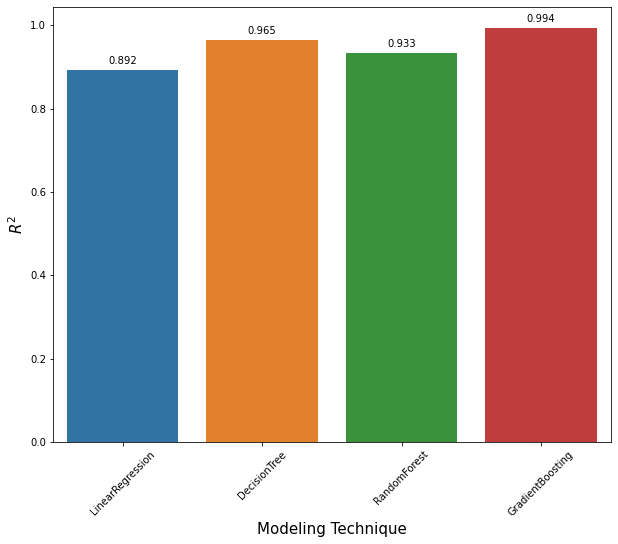

In [35]:
plt.figure(figsize=(10,8))
splot = sns.barplot(methods, scores)
for p in splot.patches:
    splot.annotate(format(p.get_height(),'.3f'), (p.get_x()+p.get_width()/2., p.get_height()),
                   ha='center', va='center', xytext=(0,9), textcoords='offset points')    
plt.xticks(rotation=45)
plt.xlabel('Modeling Technique', fontsize=15)
plt.ylabel('$R^2$', fontsize=15);

As seen from above bar chart, Gradient Boosting Regressor produces best R2_score of 0.994. Hence this can be a good model to predict Cooling Load

# Modelling for Efficiency

In [36]:
X = data_eff.drop(columns=['Efficiency'])
y = data_eff['Efficiency']

le = LabelEncoder()
y = le.fit_transform(y)

In [37]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

### Gradient Boosting

Sticking with GB, to be consistent with Regression models. Can try different classifier models, but GB works pretty good for this dataset.

In [38]:
gb = GradientBoostingClassifier(max_depth=4)
param_grid = {'learning_rate':[0.1,1,10,100],
              'n_estimators':[5,10,20,50]}
grid_search = GridSearchCV(gb, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 50}

In [39]:
gb = GradientBoostingClassifier(max_depth=4, learning_rate=0.1, n_estimators=50).fit(X_train, y_train)
y_pred = gb.predict(X_test)
print('Accuracy of Gradient Boosting Classifier on training set:{}'.format(gb.score(X_train, y_train)))
print('Accuracy of Gradient Boosting Classifier on test set:{}'.format(gb.score(X_test, y_test)))
r2_gb = accuracy_score(y_test, y_pred)
print(r2_gb)

Accuracy of Gradient Boosting Classifier on training set:0.9813780260707635
Accuracy of Gradient Boosting Classifier on test set:0.9826839826839827
0.9826839826839827


# Conclusion

To conclude, Gradient Boosting Algorithm gives the best performance, for both Regression & Classification. Hence GB would be the best suited model for making predictions in this case.